# Will a Question on Stack Overflow have an Accepted Answer?

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Zecheng Zhang, zecheng*
* *Chenchen Pan, cpan2*

## Project Overview

---


Stack Overflow is the largest online community for programmers to learn, share their knowledge, and advance their careers. The dataset we will use includes an archive of Stack Overflow content, including posts, votes, tags, badges, and user information. This dataset contains 16 tables and its total size is around 189 GB. We plan to predict whether a question have an accepted answer, which means giving a question post and some of its features, whether the author of the question will give an accepted option for an answer.


---


## Analysis of Dataset

---

### 1. Table and Feature Description:
We give the description of the tables and our preliminary features that we want to select.
* Posts_questions: this table contains the posts that are questions. It has the size 28.09 GB. The key of this table is the **id** and foreign key is **accepted_answer_id**. We treat the question whose **accepted_answer_id** is not <em>NULL</em> as label **1** and <em>NULL</em> as label **0**. Using this foreign key, we can link this table to the posts_answers table. Another foreign key is **owner_user_id** which corresponds to the users table. The following features are those that might be helpful for classifying whether the question has an accepted answer.
  - feature1 (answer_count)
  - feature2 (length of body)
  - feature3 (comment_count)
  - feature4 (favorite_count)
  - feature5 (view_count)
* Posts_answers: this table contains posts which are answers posts. The total size of this table is 28.09 GB. The key of this table is the **id** and foreign key is **parent_id** which corresponds to the posts_questions table. Another foreign key is **owner_user_id** which corresponds to the users table.The following feature might be helpful for classifying whether the question has an accepted answer.
  - feature6 (average of comment_count)
* Users: the table contains information for users. The total size of this table is 1.62 GB and the key of this table is the **id**. Following are the possible useful features.
  - feature7 (question owner's reputation)
  - feature8 (question owner's upvotes)
  - feature9 (question owner's downvotes)
  - feature10 (average reputation of answers' user)
  - feature11 (average upvotes of answers' user)
  - feature12 (average downvotes of answers' user)
* Comments: the table contains comments for posts. The key of this table is the **id** and the foreign key is **post_id** which corresponds to the key of the posts_questions table. This table has the size 13.17 GB and following is the possible feature that might be helpful.
  - feature13 (average comments score for the question)

### 2. Dataset for the Model:
* Labels: as described above, we predict whether a question will have accepted answer and the label is chosen as **1** if the question's **accepted_answer_id** is not <em>NULL</em> and vice versa.
* Features: we preliminarily select the 13 features which are described above. We will further analyze those features in the data exploration section and decide to choose to use which feature.
* Train, validation and test data: we split the data of train, validation and test by the **creation_date** of the question. We also remove the questions that have value <em>NULL</em> on **accepted_answer_id**.
  - Train: the question's **creation_date** between '2016-01-01' and '2018-06-01'. The number of train data records is 4306061.
  - Validation: the question's **creation_date** between '2018-06-02' and '2019-01-01'. The number of validation data records is 865302.
  - Test: the question's **creation_date** > '2019-01-02'. The number of test data records is 956657.

----

## Data Exploration

---

We explore the data as follows:
* Label distribution
* The correlation and visualization between feature 1-13 and the label. We design the analysis of the correlation and visualization for features as follows:
  - Feature1: we make the **answer_count** on x-axis and the number of question which has this **answer_count** to y-axis. We split the datapoints into label with 1 and 0. The datapoints with label 1 has the blue color and 0 has the red color.
  - Feature2 to feature13 follow the similar approaches that described in feature1.

---

In [0]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-fa19-pcc"

In [0]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# check the label distribution to make sure the dataset is balanced.
%%bigquery --project $project_id
SELECT
  COUNTIF(accepted_answer_id IS NOT NULL ) / COUNT(*) * 100 AS label_1_percent
FROM `bigquery-public-data.stackoverflow.posts_questions`
WHERE
  NOT(accepted_answer_id IS NOT NULL
    AND answer_count = 0)

,label_1_percent
0,52.500778


In [0]:
# feature 1
%%bigquery --project $project_id f1
SELECT
  COUNTIF( accepted_answer_id IS NOT NULL ) AS label_1,
  COUNTIF( accepted_answer_id IS NULL ) AS label_0,
  answer_count
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
WHERE
  NOT(accepted_answer_id IS NOT NULL
    AND answer_count = 0)
GROUP BY
  answer_count
ORDER BY
  answer_count

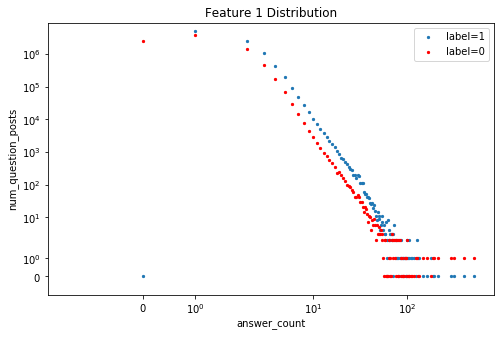

In [7]:
plt.figure(figsize=(8, 5))
plt.scatter(f1["answer_count"], f1["label_1"], s=5, label='label=1')
plt.scatter(f1["answer_count"], f1["label_0"], s=5, label='label=0', c='r')
plt.xscale('symlog')
plt.yscale('symlog')
plt.title("Feature 1 Distribution")
plt.xlabel("answer_count")
plt.ylabel("num_question_posts")
plt.ylim(-1, max(f1["label_0"] + f1["label_1"]))
plt.legend()

In [0]:
# feature 2
%%bigquery --project $project_id f2

SELECT
  COUNTIF( accepted_answer_id IS NOT NULL ) AS label_1,
  COUNTIF( accepted_answer_id IS NULL ) AS label_0,
  LENGTH(body) AS length_of_body
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
WHERE
  NOT(accepted_answer_id IS NOT NULL
    AND answer_count = 0)
GROUP BY
  LENGTH( body )

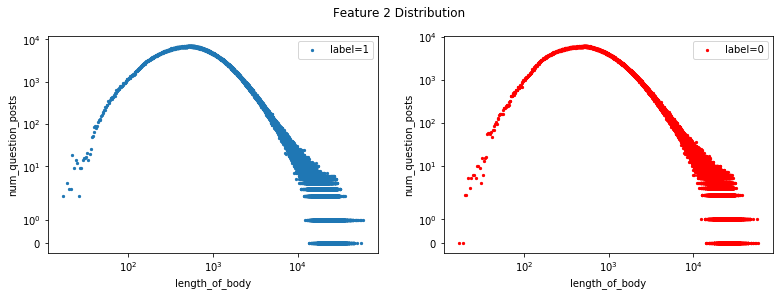

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ax[0].scatter(f2["length_of_body"], f2["label_1"], s=5, label='label=1')
ax[1].scatter(f2["length_of_body"], f2["label_0"], s=5, label='label=0', c='r')
ax[0].set_xscale('symlog')
ax[0].set_yscale('symlog')
ax[1].set_xscale('symlog')
ax[1].set_yscale('symlog')
fig.suptitle("Feature 2 Distribution")
ax[0].set_xlabel("length_of_body")
ax[0].set_ylabel("num_question_posts")
ax[1].set_xlabel("length_of_body")
ax[1].set_ylabel("num_question_posts")
# plt.ylim(-1, max(f7["label_0"] + f7["label_1"]))
ax[0].legend()
ax[1].legend()

In [0]:
# feature 3
%%bigquery --project $project_id f3
SELECT
  COUNTIF( accepted_answer_id IS NOT NULL ) AS label_1,
  COUNTIF( accepted_answer_id IS NULL ) AS label_0,
  comment_count
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
WHERE
  NOT(accepted_answer_id IS NOT NULL
    AND answer_count = 0)
GROUP BY
  comment_count
ORDER BY
  comment_count

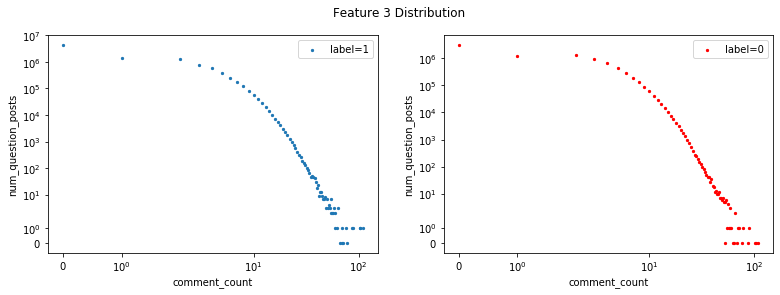

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ax[0].scatter(f3["comment_count"], f3["label_1"], s=5, label='label=1')
ax[1].scatter(f3["comment_count"], f3["label_0"], s=5, label='label=0', c='r')
ax[0].set_xscale('symlog')
ax[0].set_yscale('symlog')
ax[1].set_xscale('symlog')
ax[1].set_yscale('symlog')
fig.suptitle("Feature 3 Distribution")
ax[0].set_xlabel("comment_count")
ax[0].set_ylabel("num_question_posts")
ax[1].set_xlabel("comment_count")
ax[1].set_ylabel("num_question_posts")
# plt.ylim(-1, max(f7["label_0"] + f7["label_1"]))
ax[0].legend()
ax[1].legend()

In [0]:
# feature 4
%%bigquery --project $project_id f4
SELECT
  COUNTIF( accepted_answer_id IS NOT NULL ) AS label_1,
  COUNTIF( accepted_answer_id IS NULL ) AS label_0,
  favorite_count
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
WHERE
  NOT(accepted_answer_id IS NOT NULL
    AND answer_count = 0)
  AND favorite_count IS NOT NULL
GROUP BY
  favorite_count
ORDER BY
  favorite_count

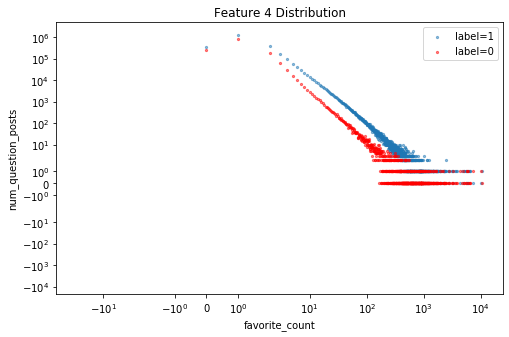

In [13]:
plt.figure(figsize=(8, 5))
plt.scatter(f4["favorite_count"], f4["label_1"], s=5, label='label=1', alpha=0.5)
plt.scatter(f4["favorite_count"], f4["label_0"], s=5, label='label=0', alpha=0.5, c='r')
plt.xscale('symlog')
plt.yscale('symlog')
plt.title("Feature 4 Distribution")
plt.xlabel("favorite_count")
plt.ylabel("num_question_posts")
# plt.ylim(-1, max(f2["label_0"] + f2["label_1"]))
plt.legend()

In [0]:
# feature 5
%%bigquery --project $project_id f5
SELECT
  COUNTIF( accepted_answer_id IS NOT NULL ) AS label_1,
  COUNTIF( accepted_answer_id IS NULL ) AS label_0,
  view_count
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
WHERE
  NOT(accepted_answer_id IS NOT NULL
    AND answer_count = 0)
GROUP BY
  view_count
ORDER BY
  view_count

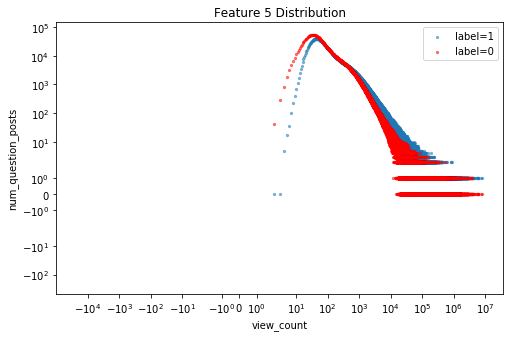

In [15]:
plt.figure(figsize=(8, 5))
plt.scatter(f5["view_count"], f5["label_1"], s=5, label='label=1', alpha=0.5)
plt.scatter(f5["view_count"], f5["label_0"], s=5, label='label=0', alpha=0.5, c='r')
plt.xscale('symlog')
plt.yscale('symlog')
plt.title("Feature 5 Distribution")
plt.xlabel("view_count")
plt.ylabel("num_question_posts")
# plt.ylim(-1, max(f2["label_0"] + f2["label_1"]))
plt.legend()

In [0]:
# feature 6
%%bigquery --project $project_id f6
SELECT
  COUNTIF( q.accepted_answer_id IS NOT NULL ) AS label_1,
  COUNTIF( q.accepted_answer_id IS NULL ) AS label_0,
  avg_table.avg_answer_comment_count
FROM
  `bigquery-public-data.stackoverflow.posts_questions` q,
  (
  SELECT
    parent_id,
    ROUND(AVG( comment_count )) AS avg_answer_comment_count
  FROM
    `bigquery-public-data.stackoverflow.posts_answers`
  GROUP BY
    parent_id) AS avg_table
WHERE
  NOT(q.accepted_answer_id IS NOT NULL
    AND q.answer_count = 0)
  AND avg_table.parent_id = q.id
GROUP BY
  avg_table.avg_answer_comment_count
ORDER BY
  avg_table.avg_answer_comment_count


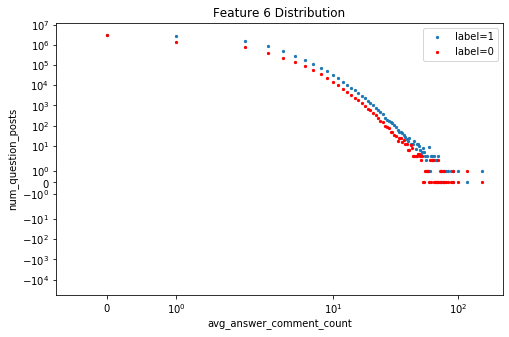

In [17]:
plt.figure(figsize=(8, 5))
plt.scatter(f6["avg_answer_comment_count"], f6["label_1"], s=5, label='label=1')
plt.scatter(f6["avg_answer_comment_count"], f6["label_0"], s=5, label='label=0', c='r')
plt.xscale('symlog')
plt.yscale('symlog')
plt.title("Feature 6 Distribution")
plt.xlabel("avg_answer_comment_count")
plt.ylabel("num_question_posts")
# plt.ylim(-1, max(f2["label_0"] + f2["label_1"]))
plt.legend()

In [0]:

# feature 7
%%bigquery --project $project_id f7

SELECT
  COUNTIF( q.accepted_answer_id IS NOT NULL ) AS label_1,
  COUNTIF( q.accepted_answer_id IS NULL ) AS label_0,
  avg_table.avg_comment_count
FROM
  `bigquery-public-data.stackoverflow.posts_questions` q,
  (
  SELECT
    AVG(a.comment_count) AS avg_comment_count,
    a.parent_id
  FROM
    `bigquery-public-data.stackoverflow.posts_answers` a
  GROUP BY
    a.parent_id ) AS avg_table
WHERE
  NOT(q.accepted_answer_id IS NOT NULL
    AND q.answer_count = 0)
  AND avg_table.parent_id = q.id
GROUP BY
  avg_table.avg_comment_count
ORDER BY
  avg_table.avg_comment_count

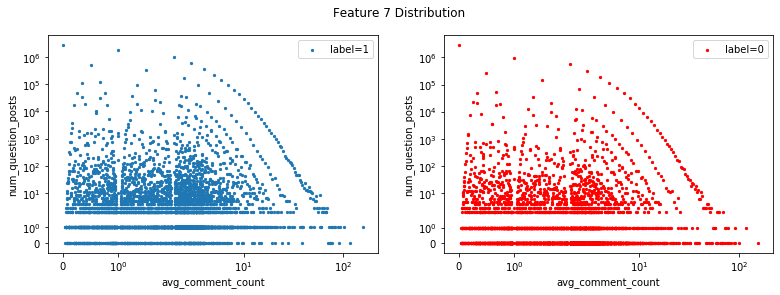

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ax[0].scatter(f7["avg_comment_count"], f7["label_1"], s=5, label='label=1')
ax[1].scatter(f7["avg_comment_count"], f7["label_0"], s=5, label='label=0', c='r')
ax[0].set_xscale('symlog')
ax[0].set_yscale('symlog')
ax[1].set_xscale('symlog')
ax[1].set_yscale('symlog')
fig.suptitle("Feature 7 Distribution")
ax[0].set_xlabel("avg_comment_count")
ax[0].set_ylabel("num_question_posts")
ax[1].set_xlabel("avg_comment_count")
ax[1].set_ylabel("num_question_posts")
# plt.ylim(-1, max(f7["label_0"] + f7["label_1"]))
ax[0].legend()
ax[1].legend()

In [0]:
# feature 7
%%bigquery --project $project_id f7

SELECT
  COUNTIF( q.accepted_answer_id IS NOT NULL ) AS label_1,
  COUNTIF( q.accepted_answer_id IS NULL ) AS label_0,
  u.reputation
FROM
  `bigquery-public-data.stackoverflow.posts_questions` q, `bigquery-public-data.stackoverflow.users` u
WHERE
  NOT(q.accepted_answer_id IS NOT NULL
    AND q.answer_count = 0)
  AND u.id = q.owner_user_id
GROUP BY
  u.reputation
HAVING COUNT(*) > 100
ORDER BY
  u.reputation

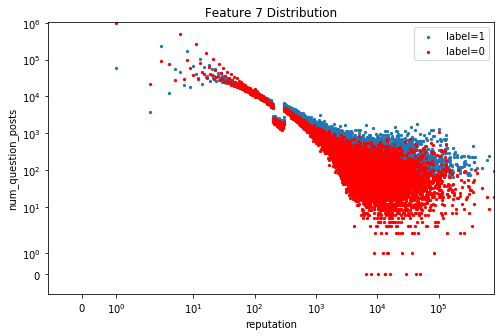

In [21]:
plt.figure(figsize=(8, 5))
plt.scatter(f7["reputation"], f7["label_1"], s=5, label='label=1')
plt.scatter(f7["reputation"], f7["label_0"], s=5, label='label=0', c='r')
plt.xscale('symlog')
plt.yscale('symlog')
plt.title("Feature 7 Distribution")
plt.xlabel("reputation")
plt.ylabel("num_question_posts")
plt.ylim(-1, max(f7["label_0"] + f7["label_1"]))
plt.xlim(-1, max(f7["reputation"]))
plt.legend()

In [0]:
# feature 8
%%bigquery --project $project_id f8

SELECT
  COUNTIF( q.accepted_answer_id IS NOT NULL ) AS label_1,
  COUNTIF( q.accepted_answer_id IS NULL ) AS label_0,
  u.up_votes
FROM
  `bigquery-public-data.stackoverflow.posts_questions` q, `bigquery-public-data.stackoverflow.users` u
WHERE
  NOT(q.accepted_answer_id IS NOT NULL
    AND q.answer_count = 0)
  AND u.id = q.owner_user_id
GROUP BY
  u.up_votes
HAVING COUNT(*) > 100
ORDER BY
  u.up_votes

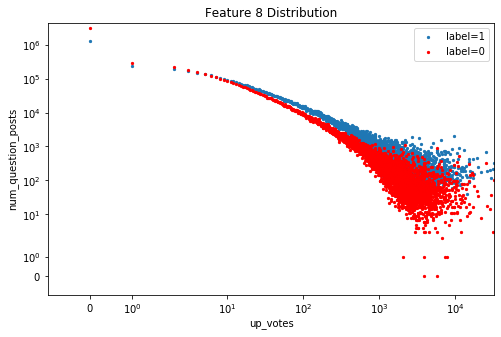

In [23]:
plt.figure(figsize=(8, 5))
plt.scatter(f8["up_votes"], f8["label_1"], s=5, label='label=1')
plt.scatter(f8["up_votes"], f8["label_0"], s=5, label='label=0', c='r')
plt.xscale('symlog')
plt.yscale('symlog')
plt.title("Feature 8 Distribution")
plt.xlabel("up_votes")
plt.ylabel("num_question_posts")
plt.ylim(-1, max(f8["label_0"] + f8["label_1"]))
plt.xlim(-1, max(f8["up_votes"]))
plt.legend()

In [0]:
# feature 9
%%bigquery --project $project_id f9

SELECT
  COUNTIF( q.accepted_answer_id IS NOT NULL ) AS label_1,
  COUNTIF( q.accepted_answer_id IS NULL ) AS label_0,
  u.down_votes
FROM
  `bigquery-public-data.stackoverflow.posts_questions` q, `bigquery-public-data.stackoverflow.users` u
WHERE
  NOT(q.accepted_answer_id IS NOT NULL
    AND q.answer_count = 0)
  AND u.id = q.owner_user_id
GROUP BY
  u.down_votes
HAVING COUNT(*) > 100
ORDER BY
  u.down_votes

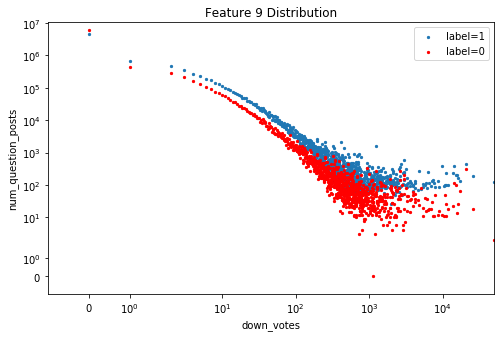

In [25]:
plt.figure(figsize=(8, 5))
plt.scatter(f9["down_votes"], f9["label_1"], s=5, label='label=1')
plt.scatter(f9["down_votes"], f9["label_0"], s=5, label='label=0', c='r')
plt.xscale('symlog')
plt.yscale('symlog')
plt.title("Feature 9 Distribution")
plt.xlabel("down_votes")
plt.ylabel("num_question_posts")
plt.ylim(-1, max(f9["label_0"] + f9["label_1"]))
plt.xlim(-1, max(f9["down_votes"]))
plt.legend()

In [0]:
# feature 10
%%bigquery --project $project_id f10

SELECT
  COUNTIF( q.accepted_answer_id IS NOT NULL ) AS label_1,
  COUNTIF( q.accepted_answer_id IS NULL ) AS label_0,
  avg_table.avg_answer_reputation
FROM
  `bigquery-public-data.stackoverflow.posts_questions` q,
  (
  SELECT
    ROUND(AVG(u.reputation), 0) AS avg_answer_reputation,
    a.parent_id
  FROM
    `bigquery-public-data.stackoverflow.posts_answers` a, `bigquery-public-data.stackoverflow.users` u
  WHERE a.owner_user_id = u.id
  GROUP BY
    a.parent_id ) AS avg_table
WHERE
  NOT(q.accepted_answer_id IS NOT NULL
    AND q.answer_count = 0)
  AND avg_table.parent_id = q.id
GROUP BY
  avg_table.avg_answer_reputation
HAVING
  COUNT(*) > 100
ORDER BY
  avg_table.avg_answer_reputation

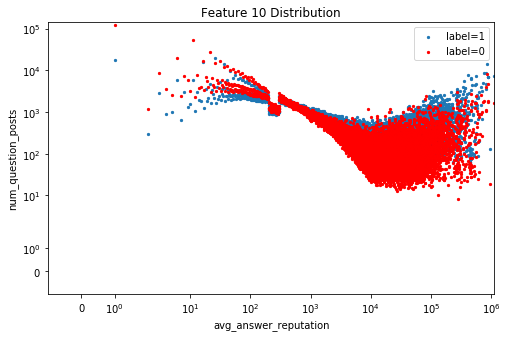

In [27]:
plt.figure(figsize=(8, 5))
plt.scatter(f10["avg_answer_reputation"], f10["label_1"], s=5, label='label=1')
plt.scatter(f10["avg_answer_reputation"], f10["label_0"], s=5, label='label=0', c='r')
plt.xscale('symlog')
plt.yscale('symlog')
plt.title("Feature 10 Distribution")
plt.xlabel("avg_answer_reputation")
plt.ylabel("num_question_posts")
plt.ylim(-1, max(f10["label_0"] + f10["label_1"]))
plt.xlim(-1, max(f10["avg_answer_reputation"]))
plt.legend()

In [0]:
# feature 11
%%bigquery --project $project_id f11

SELECT
  COUNTIF( q.accepted_answer_id IS NOT NULL ) AS label_1,
  COUNTIF( q.accepted_answer_id IS NULL ) AS label_0,
  avg_table.avg_up_votes
FROM
  `bigquery-public-data.stackoverflow.posts_questions` q,
  (
  SELECT
    ROUND(AVG(u.up_votes), 0) AS avg_up_votes,
    a.parent_id
  FROM
    `bigquery-public-data.stackoverflow.posts_answers` a, `bigquery-public-data.stackoverflow.users` u
  WHERE a.owner_user_id = u.id
  GROUP BY
    a.parent_id ) AS avg_table
WHERE
  NOT(q.accepted_answer_id IS NOT NULL
    AND q.answer_count = 0)
  AND avg_table.parent_id = q.id
GROUP BY
  avg_table.avg_up_votes
HAVING
  COUNT(*) > 100
ORDER BY
  avg_table.avg_up_votes

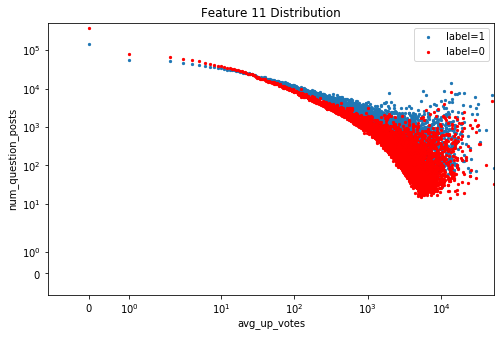

In [29]:
plt.figure(figsize=(8, 5))
plt.scatter(f11["avg_up_votes"], f11["label_1"], s=5, label='label=1')
plt.scatter(f11["avg_up_votes"], f11["label_0"], s=5, label='label=0', c='r')
plt.xscale('symlog')
plt.yscale('symlog')
plt.title("Feature 11 Distribution")
plt.xlabel("avg_up_votes")
plt.ylabel("num_question_posts")
plt.ylim(-1, max(f11["label_0"] + f11["label_1"]))
plt.xlim(-1, max(f11["avg_up_votes"]))
plt.legend()

In [0]:
# feature 12
%%bigquery --project $project_id f12

SELECT
  COUNTIF( q.accepted_answer_id IS NOT NULL ) AS label_1,
  COUNTIF( q.accepted_answer_id IS NULL ) AS label_0,
  avg_table.avg_down_votes
FROM
  `bigquery-public-data.stackoverflow.posts_questions` q,
  (
  SELECT
    ROUND(AVG(u.down_votes), 0) AS avg_down_votes,
    a.parent_id
  FROM
    `bigquery-public-data.stackoverflow.posts_answers` a, `bigquery-public-data.stackoverflow.users` u
  WHERE a.owner_user_id = u.id
  GROUP BY
    a.parent_id ) AS avg_table
WHERE
  NOT(q.accepted_answer_id IS NOT NULL
    AND q.answer_count = 0)
  AND avg_table.parent_id = q.id
GROUP BY
  avg_table.avg_down_votes
HAVING
  COUNT(*) > 100
ORDER BY
  avg_table.avg_down_votes

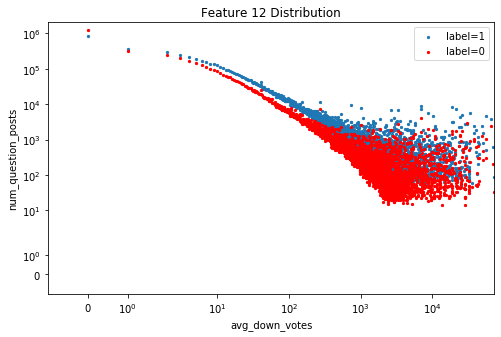

In [31]:
plt.figure(figsize=(8, 5))
plt.scatter(f12["avg_down_votes"], f12["label_1"], s=5, label='label=1')
plt.scatter(f12["avg_down_votes"], f12["label_0"], s=5, label='label=0', c='r')
plt.xscale('symlog')
plt.yscale('symlog')
plt.title("Feature 12 Distribution")
plt.xlabel("avg_down_votes")
plt.ylabel("num_question_posts")
plt.ylim(-1, max(f12["label_0"] + f12["label_1"]))
plt.xlim(-1, max(f12["avg_down_votes"]))
plt.legend()

In [0]:
# feature 13
%%bigquery --project $project_id f13

SELECT
  COUNTIF( q.accepted_answer_id IS NOT NULL ) AS label_1,
  COUNTIF( q.accepted_answer_id IS NULL ) AS label_0,
  avg_table.avg_score
FROM
  `bigquery-public-data.stackoverflow.posts_questions` q,
  (
  SELECT
    ROUND(AVG(c.score), 0) AS avg_score,
    q1.id
  FROM
    `bigquery-public-data.stackoverflow.posts_questions` q1,
    `bigquery-public-data.stackoverflow.comments` c
  WHERE
    q1.id = c.post_id
  GROUP BY
    q1.id ) AS avg_table
WHERE
  NOT(q.accepted_answer_id IS NOT NULL
    AND q.answer_count = 0)
  AND avg_table.id = q.id
GROUP BY
  avg_table.avg_score
ORDER BY
  avg_table.avg_score

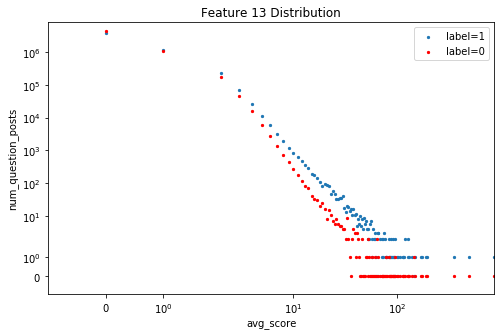

In [33]:
plt.figure(figsize=(8, 5))
plt.scatter(f13["avg_score"], f13["label_1"], s=5, label='label=1')
plt.scatter(f13["avg_score"], f13["label_0"], s=5, label='label=0', c='r')
plt.xscale('symlog')
plt.yscale('symlog')
plt.title("Feature 13 Distribution")
plt.xlabel("avg_score")
plt.ylabel("num_question_posts")
plt.ylim(-1, max(f13["label_0"] + f13["label_1"]))
plt.xlim(-1, max(f13["avg_score"]))
plt.legend()

## Feature Selection



After data exploration, we select following features since they are correlated with the label information. 

* answer_count of question posts (feature1)
* view_count of question posts (feature2)
* average comment_count of the answers for each question post  (feature3)
* up_votes of question post's owner (feature4)
* down_votes of question post's owner (feature5)
* average up_votes of the answer owners for each question post (feature6)
* average down_votes of the answer owners for each question post (feature7)

We generally follow two main ideas for the feature selection. First, we first take look at the correlations among the features for those two labels. For example, for the feature1 there is a relatively clear non-overlapping pattern between two different labels. Second, we will make sure the distribution is not biased which means that maybe most of both label has the feature value equal to 0 or <em>NULL</em>. For example, for the feature13 most of both of the labels have the same average comment score (avg_score = 0 or 1 both labels have the similar amount and the total number has been greater than 50% of total number of records). So, in these two ways, we select the aforementioned 7 features.

We display the first row of our training table below:

In [34]:
%%bigquery --project $project_id
SELECT
IF
  ( q.accepted_answer_id IS NULL,
    0,
    1) AS label,
  coalesce(q.answer_count,
    0) AS feature1,
  coalesce(q.view_count,
    0) AS feature2,
  coalesce(answer_table.avg_answer_comment_count,
    0) AS feature3,
  coalesce(user_table.up_votes,
    0) AS feature4,
  coalesce(user_table.down_votes,
    0) AS feature5,
  coalesce(answer_user_table.avg_up_votes,
    0) AS feature6,
  coalesce(answer_user_table.avg_down_votes,
    0) AS feature7
FROM
  `bigquery-public-data.stackoverflow.posts_questions` q,
  (
  SELECT
    parent_id,
    ROUND(AVG( comment_count )) AS avg_answer_comment_count
  FROM
    `bigquery-public-data.stackoverflow.posts_answers`
  GROUP BY
    parent_id) AS answer_table,
  (
  SELECT
    q.id,
    u.up_votes,
    u.down_votes
  FROM
    `bigquery-public-data.stackoverflow.posts_questions` q
  LEFT JOIN
    `bigquery-public-data.stackoverflow.users` u
  ON
    u.id = q.owner_user_id ) AS user_table,
  (
  SELECT
    a.parent_id,
    ROUND(AVG(u.up_votes)) AS avg_up_votes,
    ROUND(AVG(u.down_votes)) AS avg_down_votes
  FROM
    `bigquery-public-data.stackoverflow.users` u,
    `bigquery-public-data.stackoverflow.posts_answers` a
  WHERE
    a.owner_user_id = u.id
  GROUP BY
    a.parent_id ) AS answer_user_table
WHERE
  NOT(q.accepted_answer_id IS NOT NULL
    AND q.answer_count = 0)
  AND answer_table.parent_id = q.id
  AND user_table.id = q.id
  AND answer_user_table.parent_id = q.id
  AND q.creation_date BETWEEN '2016-01-01'
  AND '2018-06-01'
LIMIT 10

,label,feature1,feature2,feature3,feature4,feature5,feature6,feature7
0,1,2,514,1.0,0,0,318.0,12.0
1,0,2,266,1.0,10,0,6984.0,32.0
2,0,1,525,0.0,215,0,41.0,0.0
3,0,1,16,2.0,0,0,786.0,302.0
4,0,2,17,0.0,0,0,169.0,27.0
5,0,1,20,0.0,29,0,29.0,0.0
6,0,1,21,0.0,0,0,0.0,0.0
7,0,1,21,1.0,0,0,563.0,0.0
8,0,1,21,0.0,0,0,401.0,60.0
9,0,1,23,0.0,8,0,342.0,22.0


## Data Prediction

---

* Data preprocessing: after selection meaningful features, we also normalized some features before feed them to the model. We normalized feature2, feature4, feature6 and feature7 by their mean values.
* Split training, dev and test set: we split the data of train, dev and test by the **creation_date** of the question.
  - Training set: the question's **creation_date** between '2016-01-01' and '2018-06-01'. The number of training example is 4306061.
  - Dev set: the question's **creation_date** between '2018-06-02' and '2019-01-01'. The number of validation data records is 865302.
  - Test set: the question's **creation_date** > '2019-01-02'. The number of test data records is 954703.

---

In [0]:
# Run this cell to create a dataset to store our model

model_dataset_name = 'bqml_project3'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

In [0]:
# train the model on training set

%%bigquery --project $project_id
CREATE OR REPLACE MODEL `bqml_project3.project3_model` -- we'll call our model 'project3_model'
OPTIONS (model_type='logistic_reg') AS
SELECT
IF
  ( q.accepted_answer_id IS NULL,
    0,
    1) AS label,
  coalesce(q.answer_count,
    0) AS feature1,
  coalesce(q.view_count,
    0) / (
  SELECT
    AVG(q.view_count)
  FROM
    `bigquery-public-data.stackoverflow.posts_questions` q) AS feature2,
  coalesce(answer_table.avg_answer_comment_count,
    0) AS feature3,
  coalesce(user_table.up_votes,
    0) / (
  SELECT
    AVG(user_table.up_votes)
  FROM (
    SELECT
      q.id,
      u.up_votes,
      u.down_votes
    FROM
      `bigquery-public-data.stackoverflow.posts_questions` q
    LEFT JOIN
      `bigquery-public-data.stackoverflow.users` u
    ON
      u.id = q.owner_user_id ) AS user_table) AS feature4,
  coalesce(user_table.down_votes,
    0) AS feature5,
  coalesce(answer_user_table.avg_up_votes,
    0) / (
  SELECT
    AVG(answer_user_table.avg_up_votes)
  FROM (
    SELECT
      a.parent_id,
      ROUND(AVG(u.up_votes)) AS avg_up_votes,
      ROUND(AVG(u.down_votes)) AS avg_down_votes
    FROM
      `bigquery-public-data.stackoverflow.users` u,
      `bigquery-public-data.stackoverflow.posts_answers` a
    WHERE
      a.owner_user_id = u.id
    GROUP BY
      a.parent_id ) AS answer_user_table) AS feature6,
  coalesce(answer_user_table.avg_down_votes,
    0) / (
  SELECT
    AVG(answer_user_table.avg_down_votes)
  FROM (
    SELECT
      a.parent_id,
      ROUND(AVG(u.up_votes)) AS avg_up_votes,
      ROUND(AVG(u.down_votes)) AS avg_down_votes
    FROM
      `bigquery-public-data.stackoverflow.users` u,
      `bigquery-public-data.stackoverflow.posts_answers` a
    WHERE
      a.owner_user_id = u.id
    GROUP BY
      a.parent_id ) AS answer_user_table) AS feature7
FROM
  `bigquery-public-data.stackoverflow.posts_questions` q,
  (
  SELECT
    parent_id,
    ROUND(AVG( comment_count )) AS avg_answer_comment_count
  FROM
    `bigquery-public-data.stackoverflow.posts_answers`
  GROUP BY
    parent_id) AS answer_table,
  (
  SELECT
    q.id,
    u.up_votes,
    u.down_votes
  FROM
    `bigquery-public-data.stackoverflow.posts_questions` q
  LEFT JOIN
    `bigquery-public-data.stackoverflow.users` u
  ON
    u.id = q.owner_user_id ) AS user_table,
  (
  SELECT
    a.parent_id,
    ROUND(AVG(u.up_votes)) AS avg_up_votes,
    ROUND(AVG(u.down_votes)) AS avg_down_votes
  FROM
    `bigquery-public-data.stackoverflow.users` u,
    `bigquery-public-data.stackoverflow.posts_answers` a
  WHERE
    a.owner_user_id = u.id
  GROUP BY
    a.parent_id ) AS answer_user_table
WHERE
  NOT(q.accepted_answer_id IS NOT NULL
    AND q.answer_count = 0)
  AND answer_table.parent_id = q.id
  AND user_table.id = q.id
  AND answer_user_table.parent_id = q.id
  AND q.creation_date BETWEEN '2016-01-01'
  AND '2018-06-01'

In [37]:

# training stats
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_project3.project3_model`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,1,0.686322,0.686632,0.4,23773
1,0,0,0.690639,0.690757,0.2,17579


In [38]:
# evaluate on dev set
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_project3.project3_model`, (
  SELECT
  IF
  ( q.accepted_answer_id IS NULL,
    0,
    1) AS label,
  coalesce(q.answer_count,
    0) AS feature1,
  coalesce(q.view_count,
    0) / (
  SELECT
    AVG(q.view_count)
  FROM
    `bigquery-public-data.stackoverflow.posts_questions` q) AS feature2,
  coalesce(answer_table.avg_answer_comment_count,
    0) AS feature3,
  coalesce(user_table.up_votes,
    0) / (
  SELECT
    AVG(user_table.up_votes)
  FROM (
    SELECT
      q.id,
      u.up_votes,
      u.down_votes
    FROM
      `bigquery-public-data.stackoverflow.posts_questions` q
    LEFT JOIN
      `bigquery-public-data.stackoverflow.users` u
    ON
      u.id = q.owner_user_id ) AS user_table) AS feature4,
  coalesce(user_table.down_votes,
    0) AS feature5,
  coalesce(answer_user_table.avg_up_votes,
    0) / (
  SELECT
    AVG(answer_user_table.avg_up_votes)
  FROM (
    SELECT
      a.parent_id,
      ROUND(AVG(u.up_votes)) AS avg_up_votes,
      ROUND(AVG(u.down_votes)) AS avg_down_votes
    FROM
      `bigquery-public-data.stackoverflow.users` u,
      `bigquery-public-data.stackoverflow.posts_answers` a
    WHERE
      a.owner_user_id = u.id
    GROUP BY
      a.parent_id ) AS answer_user_table) AS feature6,
  coalesce(answer_user_table.avg_down_votes,
    0) / (
  SELECT
    AVG(answer_user_table.avg_down_votes)
  FROM (
    SELECT
      a.parent_id,
      ROUND(AVG(u.up_votes)) AS avg_up_votes,
      ROUND(AVG(u.down_votes)) AS avg_down_votes
    FROM
      `bigquery-public-data.stackoverflow.users` u,
      `bigquery-public-data.stackoverflow.posts_answers` a
    WHERE
      a.owner_user_id = u.id
    GROUP BY
      a.parent_id ) AS answer_user_table) AS feature7
FROM
  `bigquery-public-data.stackoverflow.posts_questions` q,
  (
  SELECT
    parent_id,
    ROUND(AVG( comment_count )) AS avg_answer_comment_count
  FROM
    `bigquery-public-data.stackoverflow.posts_answers`
  GROUP BY
    parent_id) AS answer_table,
  (
  SELECT
    q.id,
    u.up_votes,
    u.down_votes
  FROM
    `bigquery-public-data.stackoverflow.posts_questions` q
  LEFT JOIN
    `bigquery-public-data.stackoverflow.users` u
  ON
    u.id = q.owner_user_id ) AS user_table,
  (
  SELECT
    a.parent_id,
    ROUND(AVG(u.up_votes)) AS avg_up_votes,
    ROUND(AVG(u.down_votes)) AS avg_down_votes
  FROM
    `bigquery-public-data.stackoverflow.users` u,
    `bigquery-public-data.stackoverflow.posts_answers` a
  WHERE
    a.owner_user_id = u.id
  GROUP BY
    a.parent_id ) AS answer_user_table
WHERE
  NOT(q.accepted_answer_id IS NOT NULL
    AND q.answer_count = 0)
  AND answer_table.parent_id = q.id
  AND user_table.id = q.id
  AND answer_user_table.parent_id = q.id
  AND q.creation_date BETWEEN '2018-06-02'
  AND '2019-01-01'
  ))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.606271,0.731709,0.59471,0.66311,0.687714,0.626776


In [39]:
# evaluate on test set
%%bigquery --project $project_id
SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_project3.project3_model`, (
SELECT
IF
  ( q.accepted_answer_id IS NULL,
    0,
    1) AS label,
  coalesce(q.answer_count,
    0) AS feature1,
  coalesce(q.view_count,
    0) / (
  SELECT
    AVG(q.view_count)
  FROM
    `bigquery-public-data.stackoverflow.posts_questions` q) AS feature2,
  coalesce(answer_table.avg_answer_comment_count,
    0) AS feature3,
  coalesce(user_table.up_votes,
    0) / (
  SELECT
    AVG(user_table.up_votes)
  FROM (
    SELECT
      q.id,
      u.up_votes,
      u.down_votes
    FROM
      `bigquery-public-data.stackoverflow.posts_questions` q
    LEFT JOIN
      `bigquery-public-data.stackoverflow.users` u
    ON
      u.id = q.owner_user_id ) AS user_table) AS feature4,
  coalesce(user_table.down_votes,
    0) AS feature5,
  coalesce(answer_user_table.avg_up_votes,
    0) / (
  SELECT
    AVG(answer_user_table.avg_up_votes)
  FROM (
    SELECT
      a.parent_id,
      ROUND(AVG(u.up_votes)) AS avg_up_votes,
      ROUND(AVG(u.down_votes)) AS avg_down_votes
    FROM
      `bigquery-public-data.stackoverflow.users` u,
      `bigquery-public-data.stackoverflow.posts_answers` a
    WHERE
      a.owner_user_id = u.id
    GROUP BY
      a.parent_id ) AS answer_user_table) AS feature6,
  coalesce(answer_user_table.avg_down_votes,
    0) / (
  SELECT
    AVG(answer_user_table.avg_down_votes)
  FROM (
    SELECT
      a.parent_id,
      ROUND(AVG(u.up_votes)) AS avg_up_votes,
      ROUND(AVG(u.down_votes)) AS avg_down_votes
    FROM
      `bigquery-public-data.stackoverflow.users` u,
      `bigquery-public-data.stackoverflow.posts_answers` a
    WHERE
      a.owner_user_id = u.id
    GROUP BY
      a.parent_id ) AS answer_user_table) AS feature7
FROM
  `bigquery-public-data.stackoverflow.posts_questions` q,
  (
  SELECT
    parent_id,
    ROUND(AVG( comment_count )) AS avg_answer_comment_count
  FROM
    `bigquery-public-data.stackoverflow.posts_answers`
  GROUP BY
    parent_id) AS answer_table,
  (
  SELECT
    q.id,
    u.up_votes,
    u.down_votes
  FROM
    `bigquery-public-data.stackoverflow.posts_questions` q
  LEFT JOIN
    `bigquery-public-data.stackoverflow.users` u
  ON
    u.id = q.owner_user_id ) AS user_table,
  (
  SELECT
    a.parent_id,
    ROUND(AVG(u.up_votes)) AS avg_up_votes,
    ROUND(AVG(u.down_votes)) AS avg_down_votes
  FROM
    `bigquery-public-data.stackoverflow.users` u,
    `bigquery-public-data.stackoverflow.posts_answers` a
  WHERE
    a.owner_user_id = u.id
  GROUP BY
    a.parent_id ) AS answer_user_table
WHERE
  NOT(q.accepted_answer_id IS NOT NULL
    AND q.answer_count = 0)
  AND answer_table.parent_id = q.id
  AND user_table.id = q.id
  AND answer_user_table.parent_id = q.id
  AND q.creation_date > '2019-01-02'))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.590593,0.702972,0.582922,0.641901,0.688601,0.618501


## Conclusion

---

To predict whether a question post will have an accepted answer in Stack Overflow, our model can achieve around 58.29% accuracy, 64.20% f1_score and 61.85% ROC AUC score. These results show that our selection of features do have effects on classifying whether a question post will have an accepted answer. But the general accuracy or other metrics exhibit that our approach might not be very good. We provide several analysis below.

* The label distribution, after removal of <em>NULL</em> values, is relatively skewed. For example, in the training set, the number of label 0 data is around 43.88% which means that the training set might make the model learn the label 1 data relatively more and label 0 less. This is shown in the test set recall, which has the value 70.30% and this means that the model doesn't learn the negative label much.

* The classification model is too simple. As the constraints of the Bigquery ML, we only use the logistic regression to do the classification task. But from the plot of the features that we choose, we can easily see that a simple linear model cannot separate that data into two classes. Thus, a relatively more complex or nonlinear model might need to be adopted, such as the deep neural network.

* There is noise in the classification task. Our task is to classify whether a question will have an accepted answer. This task might be based on the relative subjective choice of the question owner. It is true that high quality answer will have higher possibility to be selected as an accepted answer. But the subjective judge of question owner will give some bias.

From our approaches, we find several useful insights for this classification task.

* The features are important in this task. We found that the features are crucial of this task. Adding unnecessary features will lead to decrease of validation accuracy. Our feature selection ideas seem to be useful in this classification task. First, we need to consider the relationship of the feature between two different labels, the distribution plot in previous part etc. Second, high skewed value will decrease the model accuracy. For example, most (>> 50%)of the questions' average comment score is 0 or 1 for both labels even if there are difference when the score is higher. This will make the classifier (at least in the simple linear model) learn useless information.

* Feature normalization plays important roles in this task. As the scale of different features in this task varies a lot, such as some feature has value 0 or 1 but the other might reach to thousands. The different scale will cause issues in the model training. So, we normalize the data by their means which then improve the model accuracy.

In general, we found some limitations of the dataset and our approach for this classification task and several useful insights which will help for future works in this task.

---